## 0. 기본 세팅 및 라이브러리

In [2]:
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller, acf
from scipy.stats import jarque_bera, shapiro

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [3]:
RUN_SIMPLE_MODELS = True          # LightGBM / XGBoost / RF 정도
RUN_HEAVY_MODELS = False          # AutoGluon / Transformer 등 (로컬에서는 False 권장)

## 1. 데이터 로딩

In [ ]:
# Kaggle / 로컬 둘 다 지원하는 형태로 작성
KAGGLE_PATH = Path("/kaggle/input/hull-tactical-market-prediction/")
LOCAL_PATH  = Path("../data/") 

if KAGGLE_PATH.exists():
    DATA_PATH = KAGGLE_PATH
elif LOCAL_PATH.exists():
    DATA_PATH = LOCAL_PATH
else:
    raise FileNotFoundError("train.csv 위치를 확인해서 DATA_PATH를 수정해주세요.")

print(f"Using DATA_PATH = {DATA_PATH}")

train_df = pd.read_csv(DATA_PATH / "train.csv").sort_values("date_id").reset_index(drop=True)
test_df  = pd.read_csv(DATA_PATH / "test.csv").sort_values("date_id").reset_index(drop=True)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)
print("\nTrain dtypes:\n", train_df.dtypes.value_counts())

TARGET_COL = "market_forward_excess_returns"  # 타깃으로 쓸 컬럼
RET_COL    = "forward_returns"
RF_COL     = "risk_free_rate"

Using DATA_PATH = ../data
Train shape: (9021, 98)
Test shape : (10, 99)

Train dtypes:
 float64    88
int64      10
Name: count, dtype: int64


## 2. EDA - 통계 및 결측/이상치

In [6]:
def basic_eda_summary(df: pd.DataFrame):
    print("\n=== BASIC INFO ===")
    print("Shape:", df.shape)
    print("\nDtypes:\n", df.dtypes.value_counts())
    
    print("\n=== TARGET SUMMARY ===")
    print(df[[RET_COL, RF_COL, TARGET_COL]].describe().T)
    
    print("\n=== Missing Values (Top 20) ===")
    miss = df.isna().sum().sort_values(ascending=False)
    print(miss.head(20))

basic_eda_summary(train_df)


=== BASIC INFO ===
Shape: (9021, 98)

Dtypes:
 float64    88
int64      10
Name: count, dtype: int64

=== TARGET SUMMARY ===
                                count      mean       std       min       25%  \
forward_returns                9021.0  0.000471  0.010541 -0.039754 -0.004319   
risk_free_rate                 9021.0  0.000107  0.000088 -0.000004  0.000008   
market_forward_excess_returns  9021.0  0.000053  0.010558 -0.040582 -0.004747   

                                    50%       75%       max  
forward_returns                0.000659  0.005896  0.040661  
risk_free_rate                 0.000097  0.000193  0.000317  
market_forward_excess_returns  0.000255  0.005479  0.040551  

=== Missing Values (Top 20) ===
E7     6969
V10    6049
S3     5733
M1     5547
M13    5540
M14    5540
M6     5043
V9     4539
S12    3537
M5     3283
M2     3217
S8     3009
M3     2018
E1     1784
P6     1638
E20    1616
P7     1616
P5     1574
V5     1512
S5     1511
dtype: int64


In [7]:
def missing_and_outliers_report(df: pd.DataFrame, target_col: str = TARGET_COL):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    
    # Missing
    miss = df[num_cols].isna().sum()
    miss = miss[miss > 0].sort_values(ascending=False)
    
    print("\n[Missing Summary (Top 20)]")
    print(miss.head(20))
    
    # Outliers (IQR 기반)
    print("\n[Outlier Summary (Top 30)]")
    records = []
    for col in num_cols:
        series = df[col].dropna()
        if series.empty:
            continue
        q1, q3 = series.quantile(0.25), series.quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        out_cnt = ((series < lower) | (series > upper)).sum()
        if out_cnt > 0:
            records.append((col, out_cnt, out_cnt / len(series) * 100))
    outlier_df = pd.DataFrame(records, columns=["feature", "outliers", "percent"])
    outlier_df = outlier_df.sort_values("percent", ascending=False)
    print(outlier_df.head(30))

missing_and_outliers_report(train_df)


[Missing Summary (Top 20)]
E7     6969
V10    6049
S3     5733
M1     5547
M14    5540
M13    5540
M6     5043
V9     4539
S12    3537
M5     3283
M2     3217
S8     3009
M3     2018
E1     1784
P6     1638
E20    1616
P7     1616
P5     1574
V5     1512
V13    1511
dtype: int64

[Outlier Summary (Top 30)]
            feature  outliers    percent
4                D6      2148  23.811107
20               E4      1607  20.049906
3                D5      1718  19.044452
22               E7       357  17.397661
10              E12      1311  16.356831
9               E11      1234  15.396132
7                D9      1290  14.299967
6                D8      1287  14.266711
51               S5      1025  13.648469
21               E6      1011  12.613849
44               P6       815  11.038873
12              E14       754   9.407361
46               P8       718   8.958203
11              E13       604   7.535870
23               E8       557   6.949470
18              E20       513   6.9

## 3. 시계열 / 분포 EDA

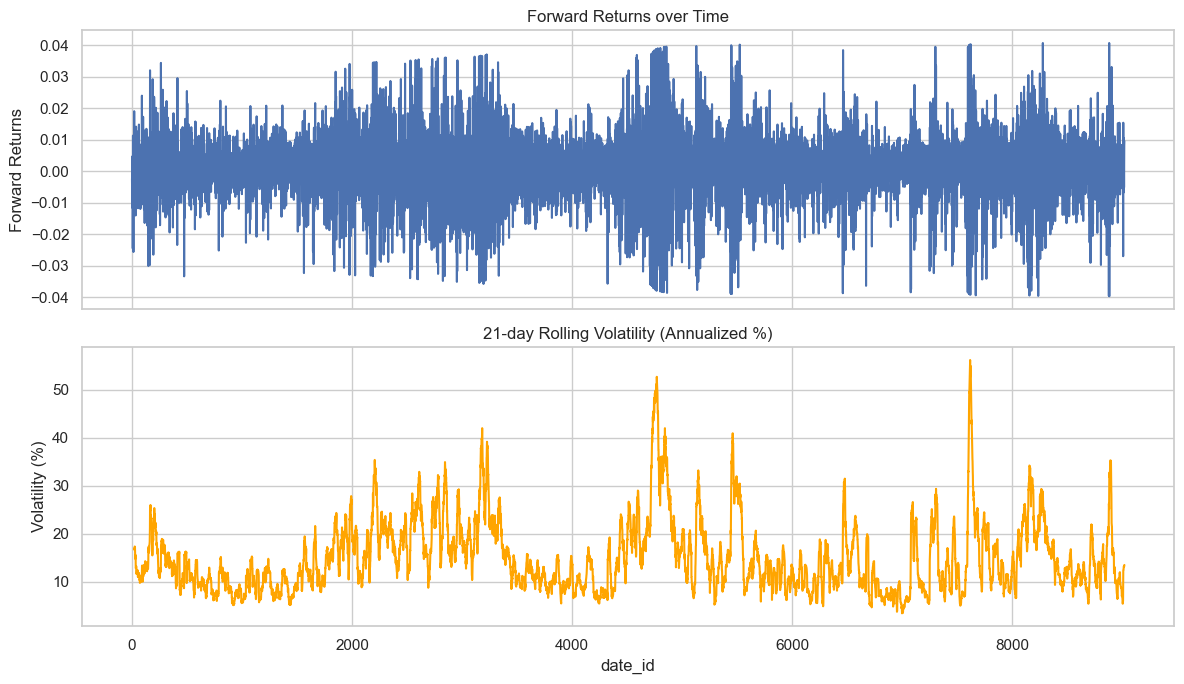

In [9]:
# 3-1. 타깃 시계열 & rolling volatility
def plot_target_time_series(df: pd.DataFrame):
    fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

    # forward return
    sns.lineplot(x="date_id", y=RET_COL, data=df, ax=axes[0])
    axes[0].set_title("Forward Returns over Time")
    axes[0].set_ylabel("Forward Returns")

    # rolling vol (21d)
    roll_vol = df[RET_COL].rolling(21).std() * np.sqrt(252) * 100
    sns.lineplot(x=df["date_id"], y=roll_vol, ax=axes[1], color="orange")
    axes[1].set_title("21-day Rolling Volatility (Annualized %)")
    axes[1].set_ylabel("Volatility (%)")
    axes[1].set_xlabel("date_id")
    plt.tight_layout()
    plt.show()

plot_target_time_series(train_df)

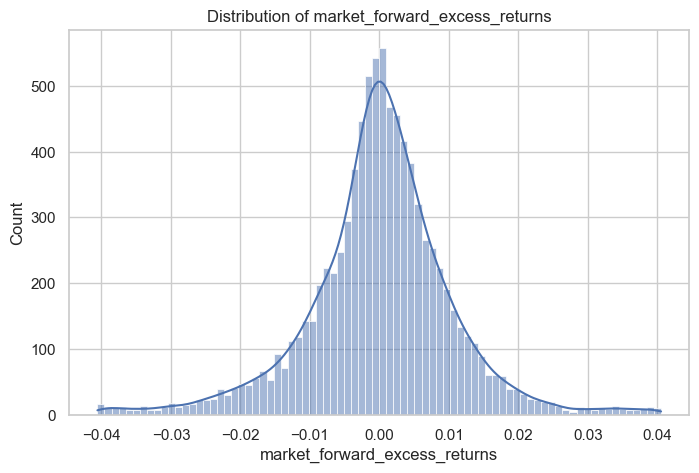

In [10]:
# 3-2. 타깃 분포 (히스토그램 + KDE)
def plot_target_distribution(df: pd.DataFrame, col: str = TARGET_COL):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.histplot(df[col].dropna(), bins=80, kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")
    plt.show()

plot_target_distribution(train_df, TARGET_COL)

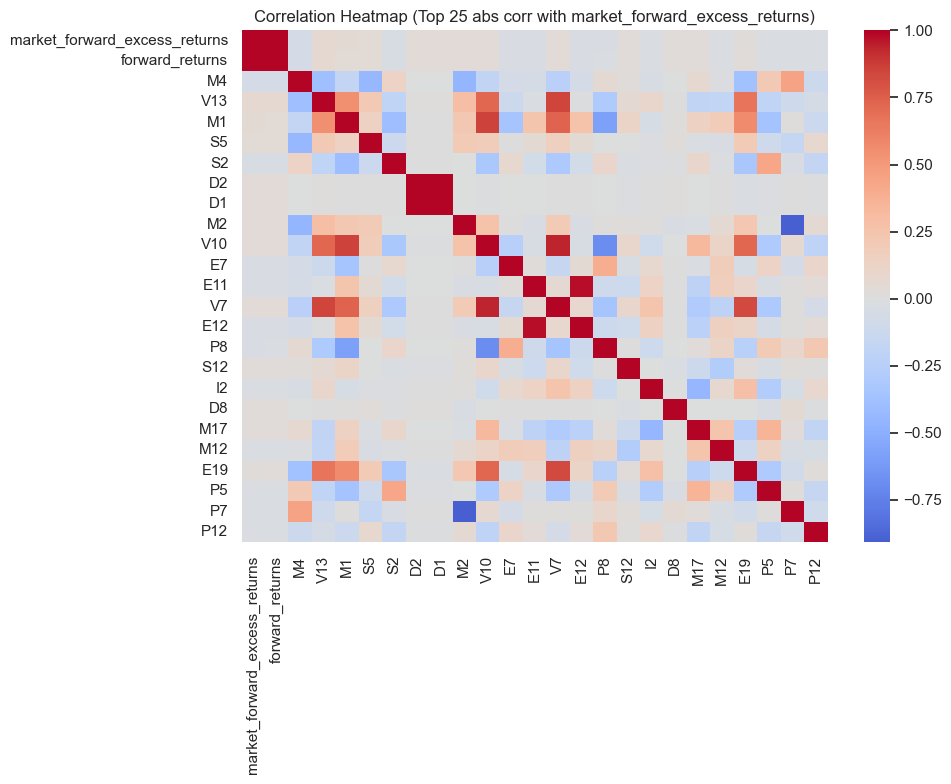

In [11]:
# 3-3. 상관관계 heatmap (상위 N개)
def plot_corr_heatmap(df: pd.DataFrame, target_col: str = TARGET_COL, top_n: int = 25):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col not in num_cols:
        print("[WARN] target_col not numeric or not found.")
        return
    
    corr_with_target = df[num_cols].corr()[target_col].abs().sort_values(ascending=False)
    top_features = corr_with_target.head(top_n).index.tolist()
    
    corr_matrix = df[top_features].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
    plt.title(f"Correlation Heatmap (Top {top_n} abs corr with {target_col})")
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(train_df, TARGET_COL, top_n=25)

## 4. 통계 검증 (정상성/자기상관/정규성)

In [12]:
def statistical_tests_on_target(df: pd.DataFrame, col: str = TARGET_COL):
    series = df[col].dropna()

    print(f"\n=== Statistical Tests for {col} ===")
    
    # ADF (단위근/정상성)
    adf_res = adfuller(series)
    print(f"ADF Statistic: {adf_res[0]:.4f}, p-value: {adf_res[1]:.4g}")
    
    # Jarque-Bera (정규성)
    jb_stat, jb_p = jarque_bera(series)
    print(f"Jarque-Bera: stat={jb_stat:.4f}, p-value={jb_p:.4g}")
    
    # Shapiro (정규성) – 표본 제한 때문에 일부만 사용
    sample = series.sample(min(5000, len(series)), random_state=42)
    sh_stat, sh_p = shapiro(sample)
    print(f"Shapiro-Wilk: stat={sh_stat:.4f}, p-value={sh_p:.4g}")
    
    # ACF (자기상관 몇 개)
    lag_acf = acf(series, nlags=20, fft=True)
    print("\nACF (lags 0~20):")
    for i, v in enumerate(lag_acf[:10]):
        print(f"  lag {i}: {v:.4f}")

statistical_tests_on_target(train_df, TARGET_COL)


=== Statistical Tests for market_forward_excess_returns ===
ADF Statistic: -17.5318, p-value: 4.233e-30
Jarque-Bera: stat=1940.6388, p-value=0
Shapiro-Wilk: stat=0.9611, p-value=1.205e-34

ACF (lags 0~20):
  lag 0: 1.0000
  lag 1: -0.0450
  lag 2: -0.0167
  lag 3: -0.0170
  lag 4: -0.0134
  lag 5: -0.0233
  lag 6: -0.0240
  lag 7: 0.0020
  lag 8: -0.0214
  lag 9: 0.0190


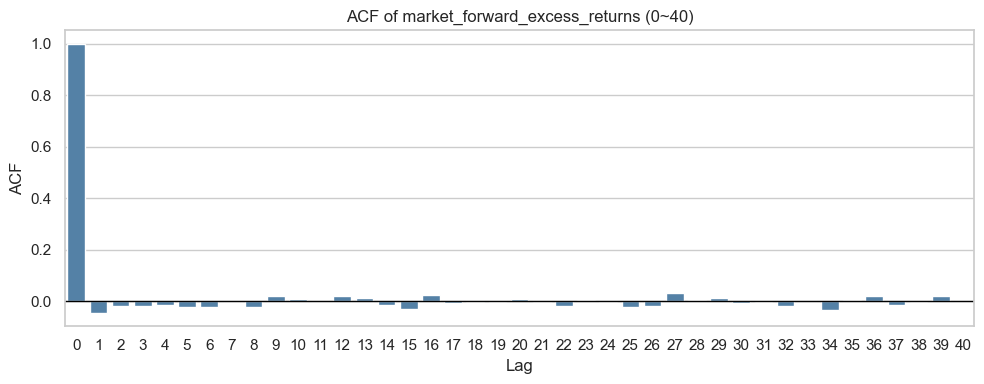

In [ ]:
# ACF 시각화
def plot_acf_series(df: pd.DataFrame, col: str = TARGET_COL, nlags: int = 40):
    series = df[col].dropna()
    vals = acf(series, nlags=nlags, fft=True)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=list(range(len(vals))), y=vals, color="steelblue")
    plt.axhline(0, color="black", linewidth=1)
    plt.title(f"ACF of {col} (0~{nlags})")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.tight_layout()
    plt.show()

plot_acf_series(train_df, TARGET_COL, nlags=40)

In [14]:
# 다중공선성
def compute_vif(df: pd.DataFrame, target_col: str = TARGET_COL, max_features: int = 40):
    """상위 |corr| 기준으로 max_features개만 골라서 VIF 계산 (너무 많으면 폭발하니까)."""
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    
    # 결측 제거용
    tmp = df[num_cols + [target_col]].dropna()
    # 상관계수 기준 상위 max_features 개 선택
    corr = tmp.corr()[target_col].abs().sort_values(ascending=False)
    selected = corr.index.tolist()[:max_features]
    
    X = tmp[selected].fillna(0.0)  # 안정성을 위해 NA는 0으로 채움
    vif_data = []
    for i, col in enumerate(X.columns):
        vif_val = variance_inflation_factor(X.values, i)
        vif_data.append((col, vif_val))
    vif_df = pd.DataFrame(vif_data, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)
    return vif_df

vif_df = compute_vif(train_df, TARGET_COL, max_features=40)
print("\n=== VIF (Top 20) ===")
print(vif_df.head(20))


=== VIF (Top 20) ===
                          feature          VIF
1                 forward_returns  7829.269023
0   market_forward_excess_returns  7808.354101
12                            P11   651.151949
33                             V9   569.886780
2                             P10   533.040053
29                            V10   271.865834
7                              E3   165.965777
19                             E2   128.722916
3                              P8   117.750062
5                              P2   115.267925
28                             V7   111.045971
15                            S11    43.334351
38                             V8    41.047257
14                             S4    30.649547
32                            M17    27.977265
10                            E20    27.071762
18                             P1    26.768438
23                            S10    22.680531
20                             M1    19.782236
26                             I4    1

본 데이터셋의 EDA 및 통계 검정 결과,
초과수익률 자체는 평균 0에 가까운 고주파 노이즈 형태를 띠며
자기상관이 거의 없는 무방향성(random walk) 구조를 보였다.

그러나 변동성은 뚜렷한 군집화(volatility clustering) 패턴을 보이며,
macro·momentum·volatility 계열 특징들은 높은 multicollinearity를 보여
소수의 공통 요인(latent factor)에 의해 움직이는 구조가 확인되었다.

이러한 특성은 단일 피처 기반 예측이 매우 어렵고,
시계열 lag·rolling 변환, regime indicator, factor 압축(PCA),
그리고 tree-based 또는 sequence model이 필수적임을 시사한다.

즉, 방향성 신호는 약하지만
regime 기반 신호는 예측 가능성이 있다는 결론이 도출된다.